Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 2  
Due: May 6, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
wd = "/mnt/Backups/jmhu"

data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

### Load data

In [4]:
df = pd.read_csv(data_dir+"population_data.csv")
df.head()

,Year,Hare,Lynx
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


#### Define functions

In [5]:
def densify(t, y, dt):
    from scipy.interpolate import interp1d
    f = interp1d(t, y, kind='cubic')
    tnew = np.arange(t[0], t[-1], dt)
    ynew = f(tnew)
    return(tnew, ynew)

def DMD(X, Xprime, r, dt=2):
    '''Dynamic Mode Decomposition Function from book'''
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    Omega = np.log(np.diag(Lambda))/dt
    return Phi, Omega, b, Lambda

def forecast(Phi, Omega, t, b):
    f = Phi@np.exp(Omega*t)*b
    return(f)

In [6]:
# Figure formatting
y_position=0.92
fontsize=16
weight="bold"

## Question 1. Develop a DMD model to forecast the future population states

#### Set-up matrices

In [7]:
# Hare and Lynx columns
X=df.values[:, 1:3]
X.shape

(30, 2)

In [8]:
make_it_dense = 5

if make_it_dense is not None:
    # For DMD with interpolation
    t = df.Year.values
    dt = (t[1] - t[0])/make_it_dense # make 100 times more points

    # Interpolate for more points
    years, dense_hare = densify(t, df.Hare.values, dt)
    years, dense_lynx = densify(t, df.Lynx.values, dt)

    X_dense = np.stack((dense_hare, dense_lynx)).T # in form time, states

    # DMD dense set-up
    X = X_dense[:-1,:]
    Xprime = X_dense[1:,:]

else:
    # For DMD without interpolation
    X = df.values[:-1, 1:3]
    Xprime = df.values[1:, 1:3]

# Transpose matrices --> two state variables, want observations on other dimension
X=X.T
Xprime=Xprime.T
print(X.shape, Xprime.shape)

(2, 144) (2, 144)


#### Run DMD

In [9]:
r=2

Phi, Omega, b, Lambda = DMD(X, Xprime, r)

print(" Phi : Omega : b ", )
print(Phi.shape, Omega.shape, b.shape)

 Phi : Omega : b 
(2, 2) (2,) (2,)


#### Check values

In [10]:
print("Phi:", Phi, "\n")
print("Lambda:", Lambda, "\n")
print("Omega:", Omega, "\n")
print("b:", b, "\n")

Phi: [[-0.81833442-0.15178844j -0.81833442+0.15178844j]
 [-0.46735257+0.21165875j -0.46735257-0.21165875j]] 

Lambda: [[0.97633761+0.05190062j 0.        +0.j        ]
 [0.        +0.j         0.97633761-0.05190062j]] 

Omega: [-0.01126796+0.02655425j -0.01126796-0.02655425j] 

b: [-18.61671244-34.48679298j -18.61671244+34.48679298j] 



#### DMD reconstruction as in dmd_intro.m

In [11]:
t = X.shape[1]
u_modes = np.zeros((2, t))

dt = 2 # units of array shift - 2 years between observations
time_vector = dt*np.arange(-1, t-1)

for i in np.arange(0, t):
    u_modes[:, i]=b * np.exp(Omega * time_vector[i])

Xdmd = Phi @ u_modes

print(t, u_modes.shape, time_vector.shape, Xdmd.shape)

144 (2, 144) (144,) (2, 144)


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


#### Plot DMD reconstruction

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


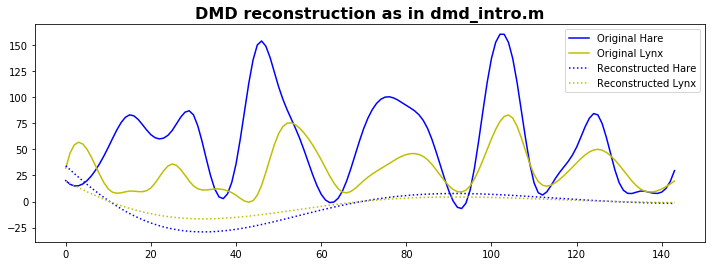

In [12]:
h=0
l=1

labels=["Hare", "Lynx"]

plt.figure(figsize=(12, 4))
plt.plot(X.T[:,h], "b", label=str("Original " + labels[h]))
plt.plot(X.T[:,l], "y", label=str("Original " + labels[l]))

plt.plot(Xdmd.T[:,h], "b:", label="Reconstructed " + labels[h])
plt.plot(Xdmd.T[:,l], "y:", label="Reconstructed " + labels[l])

plt.title("DMD reconstruction as in dmd_intro.m", fontsize=fontsize, weight=weight);
plt.legend()

### Note: with only 29 observations apiece (original DMD dataset), there are no imaginary components for Lambda.  Any interpolation improves this

In [13]:
forecast_modes = np.zeros((2, t))

for i in np.arange(0, t):
    forecast_modes[:, i] = forecast(Phi, Omega, i, b)

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


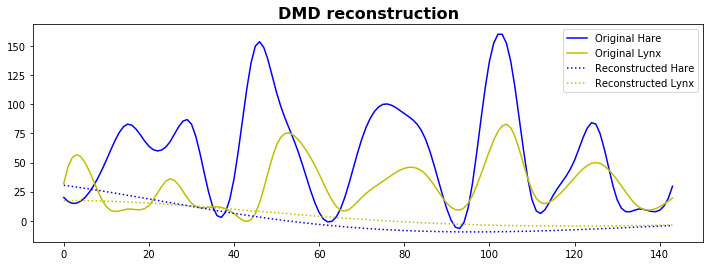

In [14]:
h=0
l=1

labels=["Hare", "Lynx"]

plt.figure(figsize=(12, 4))
plt.plot(X.T[:,h], "b", label=str("Original " + labels[h]))
plt.plot(X.T[:,l], "y", label=str("Original " + labels[l]))

plt.plot(forecast_modes.T[:,h], "b:", label=str("Reconstructed " + labels[h]))
plt.plot(forecast_modes.T[:,l], "y:", label=str("Reconstructed " + labels[l]))

plt.title("DMD reconstruction", fontsize=fontsize, weight=weight);

plt.legend()

## Seems like this should be the better choice where Phi is entirely used at every time step...

# Forecasting:

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


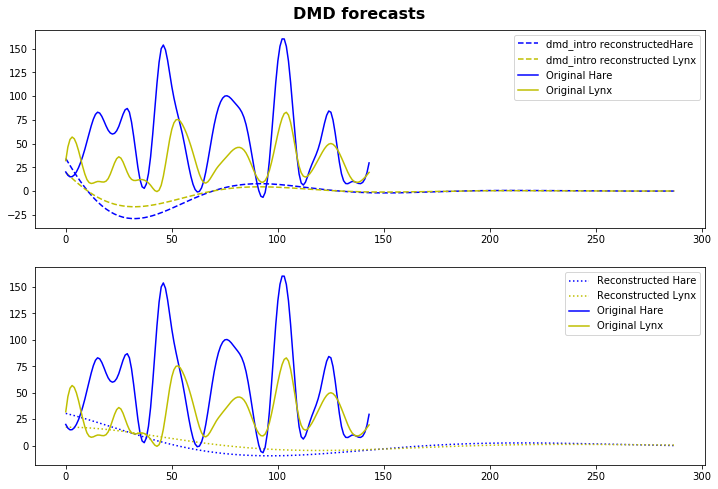

In [15]:
t_forecast = t*2

# As in DMD_intro.m
u_modes = np.zeros((r, t_forecast))
time_vector = dt*np.arange(-1, t_forecast-1)

for i in np.arange(0, t_forecast):
    u_modes[:, i]=b * np.exp(Omega * time_vector[i])

Xdmd = Phi @ u_modes

# Using forecast function
forecast_modes = np.zeros((2, t_forecast))

for i in np.arange(0, t_forecast):
    forecast_modes[:, i] = forecast(Phi, Omega, i, b)
    
h=0
l=1

labels=["Hare", "Lynx"]

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(Xdmd.T[:,h], "b--", label="dmd_intro reconstructed" + labels[h])
axes[0].plot(Xdmd.T[:,l], "y--", label="dmd_intro reconstructed " + labels[l])

axes[1].plot(forecast_modes.T[:,h], "b:", label=str("Reconstructed " + labels[h]))
axes[1].plot(forecast_modes.T[:,l], "y:", label=str("Reconstructed " + labels[l]))

for ax in axes:
    ax.plot(X.T[:,h], "b", label=str("Original " + labels[h]))
    ax.plot(X.T[:,l], "y", label=str("Original " + labels[l]))
    ax.legend()
    
plt.suptitle("DMD forecasts", 
             y=y_position, fontsize=fontsize, weight=weight);

#### Save the DMD model components, noting densified points

DMD model reconstruction requires:  Phi, b, Omega, and r

In [16]:
DMD_components = [Phi, b, Omega, r]

DMD_fn = model_dir + str("DMD" + "_" + str(make_it_dense) + "pts.pkl")

if not os.path.exists(DMD_fn):
    with open(DMD_fn, "wb") as file:
        pickle.dump(DMD_components, file)   
else:
    print(DMD_fn, "exists")

/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/DMD_5pts.pkl exists


---

## Question 2.  Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.

In [17]:
X=df.Hare.values
Y=df.Lynx.values

from scipy.linalg import hankel

# Construct Hankel matrix
H_X = hankel(X)
H_Y = hankel(Y)

print(H_X.shape, H_Y.shape)

(30, 30) (30, 30)


21
20


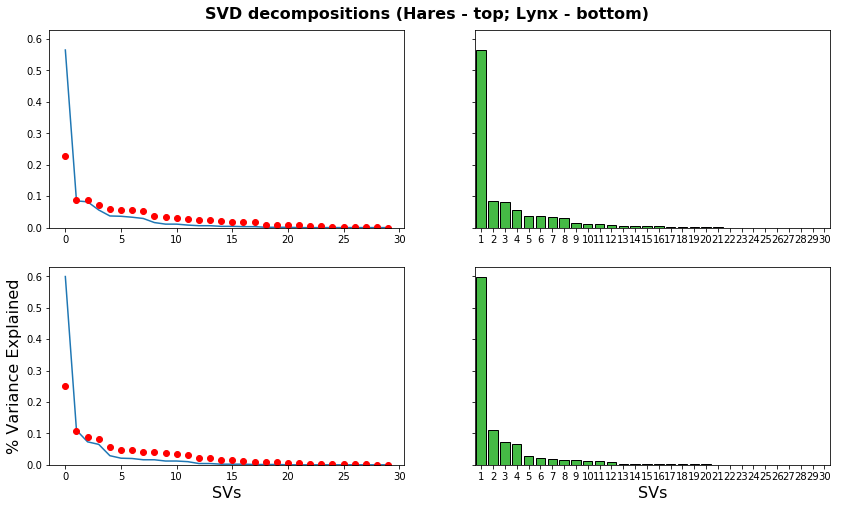

In [18]:
import seaborn as sns

# Take SVD of H_X
u, s, v = np.linalg.svd(H_X)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))

fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
ax[0,0].plot(var_explained)
ax[0,0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");
ax[1,0].set_xlabel('SVs', fontsize=16)
ax[1,0].set_ylabel('% Variance Explained', fontsize=16)
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax[0,1])

# Take SVD of H_Y
u, s, v = np.linalg.svd(H_Y)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))
ax[1,0].plot(var_explained)
ax[1,0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");


sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax[1,1])
plt.xlabel('SVs', fontsize=16);

plt.suptitle("SVD decompositions (Hares - top; Lynx - bottom)", 
             y=y_position, fontsize=fontsize, weight=weight);

#### SVD of Hankel matrix shows that there are 20 and 21 non-zero modes for hare and lynx populations based on this small dataset

This suggests that there are quite a few latent variables not being measured in this dynamic system as we are only measuring 2 variables (lynx and hare)

### Check combined Hankel matrix

Hankel shape: (60, 60)
39


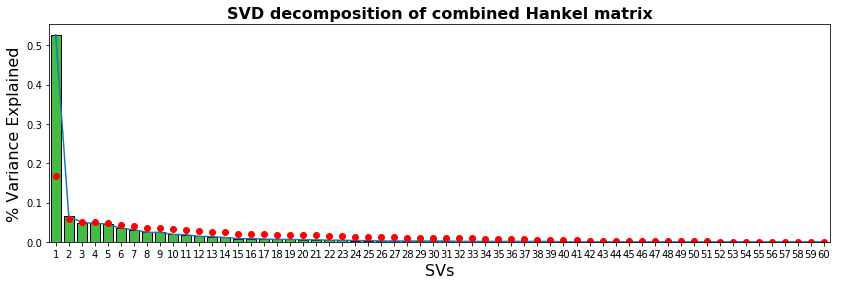

In [19]:
import seaborn as sns

# Construct Hankel matrix
combined=df.values[:, 1:]
H_combined = hankel(combined)
print("Hankel shape:", H_combined.shape)

# Take SVD of H
u, s, v = np.linalg.svd(H_combined)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))

fig, ax = plt.subplots(1, figsize=(14, 4), sharey=True)
ax.plot(var_explained)
ax.plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");
ax.set_xlabel('SVs', fontsize=16)
ax.set_ylabel('% Variance Explained', fontsize=16)
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax);
plt.title("SVD decomposition of combined Hankel matrix", fontsize=fontsize, weight=weight);

SVD on combined matrix shows 39 potential variables involved in the system

#### Run DMD on combined Hankel matrix, interpolating to same degree as DMD models

In [20]:
# make_it_dense = 5

if make_it_dense is not None:
    # With interpolation
    t = df.Year.values
    dt = (t[1] - t[0])/make_it_dense

    # Interpolate for more points
    years, dense_hare = densify(t, df.Hare.values, dt)
    years, dense_lynx = densify(t, df.Lynx.values, dt)

    X_dense = np.stack((dense_hare, dense_lynx)).T # in form time, states
    H_combined = hankel(X_dense)

else:
    # Without interpolation
    H_combined = hankel(df.values[:, 1:3])
    
H_combined.shape

(290, 290)

In [21]:
X=H_combined[1:, :]
Xprime=H_combined[:-1, :]

X.shape, Xprime.shape

((289, 290), (289, 290))

In [22]:
r=39

Phi, Omega, b, Lambda = DMD(X, Xprime, r)

print(" Phi : Omega : b ", )
print(Phi.shape, Omega.shape, b.shape)

 Phi : Omega : b 
(289, 39) (39,) (39,)


#### DMD reconstruction using Hankel matrices

In [23]:
t = X.shape[1]
u_modes = np.zeros((r, t))

dt = 2 # units of array shift - 2 years between observations
time_vector = dt*np.arange(-1, t-1)

for i in np.arange(0, t):
    u_modes[:, i]=b * np.exp(Omega * time_vector[i])

Xdmd = Phi @ u_modes

print(t, u_modes.shape, time_vector.shape, Xdmd.shape)

290 (39, 290) (290,) (289, 290)


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


#### Plot DMD reconstruction

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


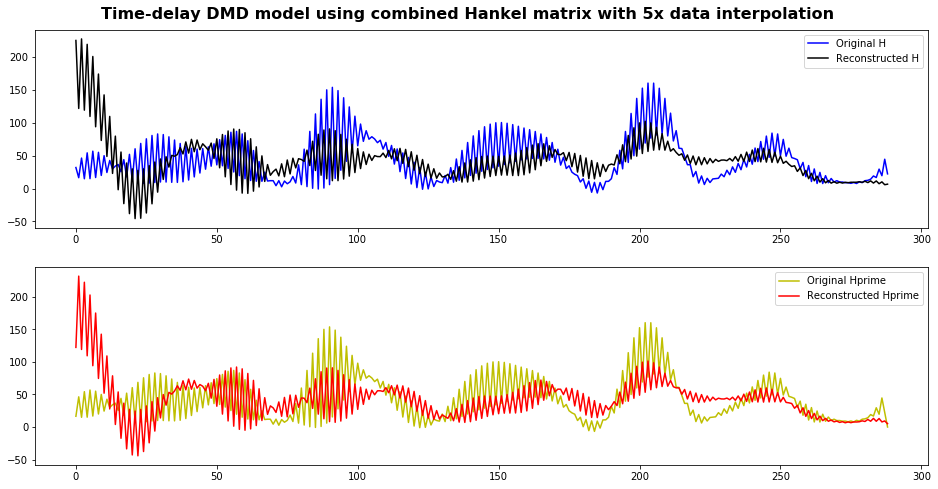

In [24]:
labels=["H", "Hprime"]
style_og=["b", "y"]
style_recon=["k-", "r-"]

fig, ax = plt.subplots(2, 1, figsize=(16,8))

for i in range(0, len(labels)):
    ax[i].plot(X.T[i], style_og[i], label=str("Original " + labels[i]))
    ax[i].plot(Xdmd.T[i], style_recon[i], label="Reconstructed " + labels[i])
    ax[i].legend()
    
plt.suptitle("Time-delay DMD model using combined Hankel matrix with 5x data interpolation", 
             y=y_position, fontsize=fontsize, weight=weight);

#### Save DMD with Hankel model with pickle

In [25]:
DMD_components = [Phi, b, Omega, r]

DMD_fn = model_dir + str("DMD_combinedHankel" + "_" + str(make_it_dense) + "pts.pkl")

if not os.path.exists(DMD_fn):
    with open(DMD_fn, "wb") as file:
        pickle.dump(DMD_components, file)   
else:
    print(DMD_fn, "exists")

/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/DMD_combinedHankel_5pts.pkl exists
